In [220]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
import numpy as np

In [196]:
data = pd.read_csv("../prices_species.csv").drop(columns="Unnamed: 0")

In [197]:
data.head()

,especie/ producto,month,price,year
0,Ave,ene,7.047264,2024
1,Ovino,ene,5.613983,2024
2,Porcino,ene,7.233857,2024
3,Vacuno,ene,5.848160,2024
4,Caprino,ene,4.798561,2024


In [198]:
month_map = {
    "ene": 1, "feb": 2, "mar": 3, "abr": 4, "may": 5, "jun": 6,
    "jul": 7, "ago": 8, "set": 9, "oct": 10, "nov": 11, "dic": 12
}

data["month_num"] = data["month"].str.lower().str.strip().replace(month_map)

data["especie/ producto"] = data["especie/ producto"].astype(str).str.lower()


/tmp/ipykernel_81781/1318759530.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["month_num"] = data["month"].str.lower().str.strip().replace(month_map)


In [199]:
data["especie/ producto"].unique()

array(['ave', 'ovino', 'porcino', 'vacuno', 'caprino', 'alpaca', 'llama',
       'huevo gallina', 'fibra alpaca', 'fibra llama', 'lana ovino'],
      dtype=object)

ADF statistic = -0.561, p-value = 0.880
Significant PACF lags: []
ADF statistic = 0.939, p-value = 0.994
Significant PACF lags: []
ADF statistic = 0.687, p-value = 0.990
Significant PACF lags: []
ADF statistic = -1.102, p-value = 0.714
Significant PACF lags: []
ADF statistic = -2.136, p-value = 0.230
Significant PACF lags: []
ADF statistic = -2.259, p-value = 0.186
Significant PACF lags: []
ADF statistic = -1.090, p-value = 0.719
Significant PACF lags: []
ADF statistic = -0.644, p-value = 0.861
Significant PACF lags: []
ADF statistic = -1.306, p-value = 0.627
Significant PACF lags: []
ADF statistic = -1.676, p-value = 0.444
Significant PACF lags: []
ADF statistic = -1.222, p-value = 0.664
Significant PACF lags: []


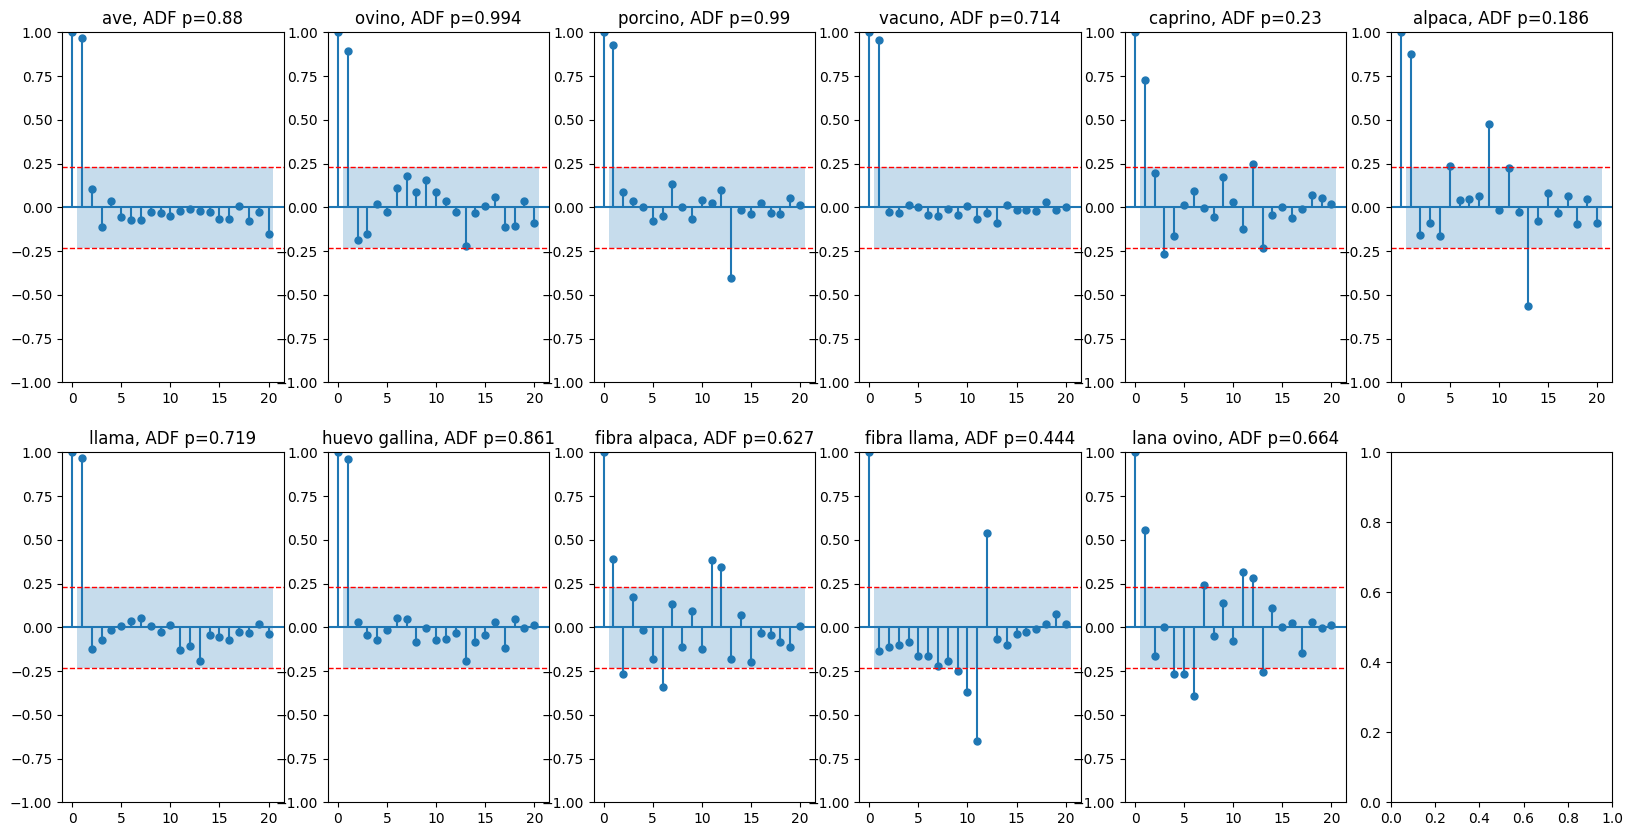

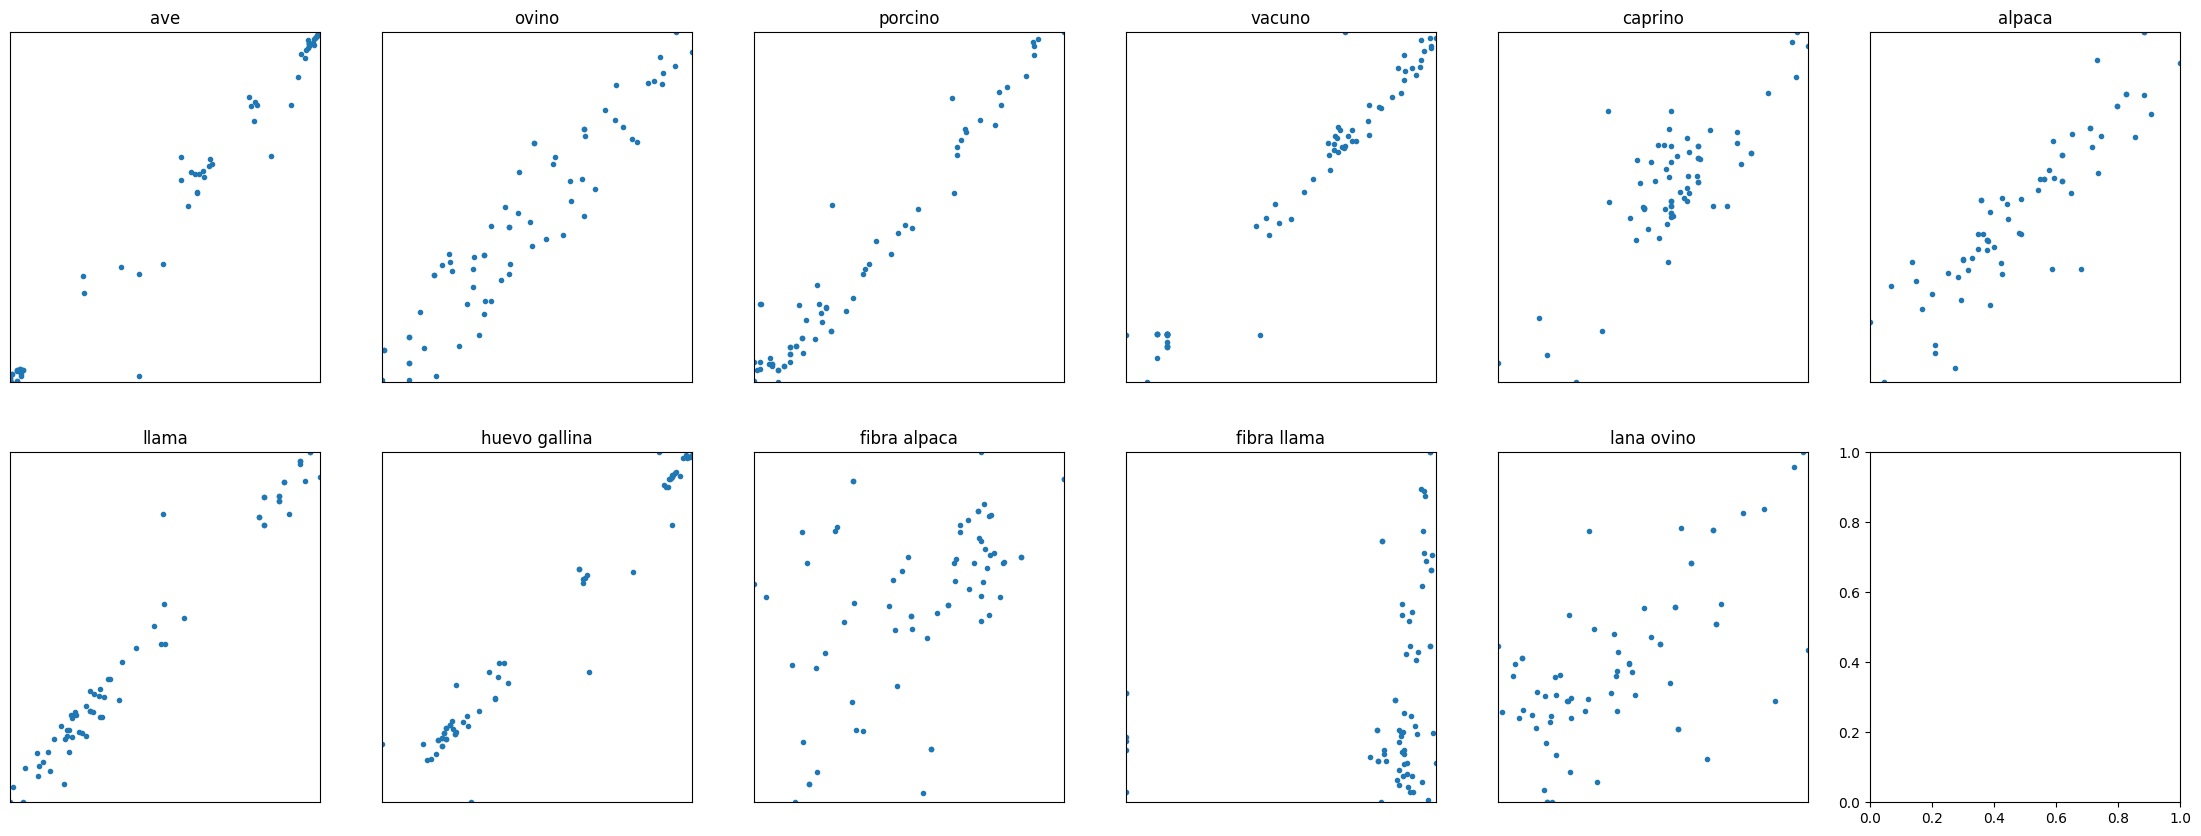

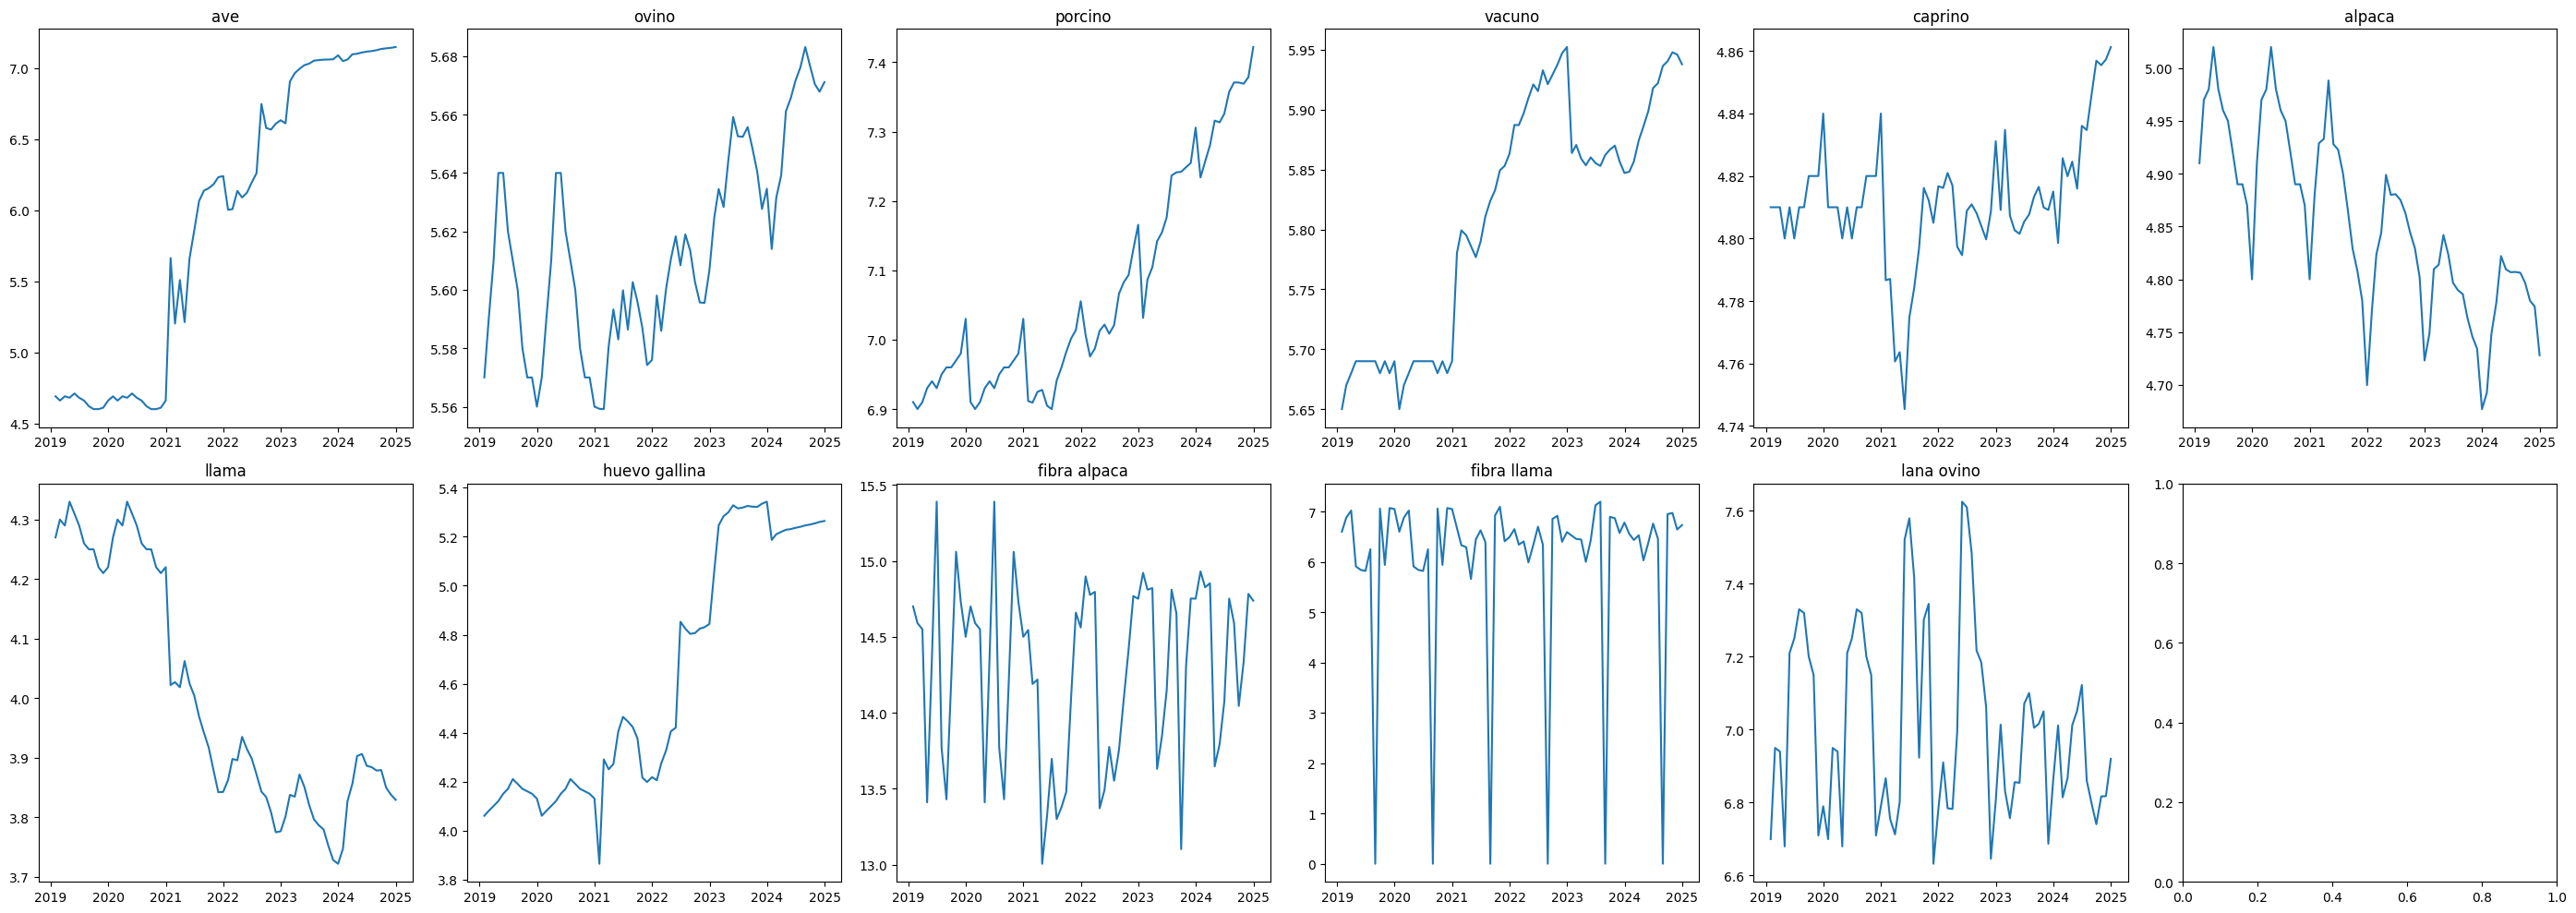

In [221]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
fig_quality, axes_quality = plt.subplots(ncols=6, nrows=2, figsize=(28,10))
fig_sp, axes_spe = plt.subplots(ncols=6, nrows=2, figsize=(28,10))

species = data["especie/ producto"].unique()
for ax,ax_q,ax_s,specie in zip(axes.ravel(), axes_quality.ravel(), axes_spe.ravel() ,species ):
    
    # selection specie
    df = data[data["especie/ producto"]==specie].sort_values( by=["year","month_num"], ascending=True).reset_index(drop=True)
    df.index = pd.date_range(start="2019-01-01", periods=len(df), freq="ME")

    # adf test
    #result = adfuller(df["price"]) # p>0.05
    df_diff = df["price"]#.diff().dropna()
    result = adfuller(df_diff)
    print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

    # plot the pacf
    nlags = 20
    N = len(df_diff)
    conf = 1.96 / np.sqrt(N)
    plot_pacf(df_diff, lags=nlags, ax=ax)
    # Add threshold lines
    ax.axhline(conf, color="red", linestyle="--", linewidth=1)
    ax.axhline(-conf, color="red", linestyle="--", linewidth=1)
    ax.set_title(f"{specie}, ADF p={round(result[1], 3)}")
    pacf_vals, confint = pacf(df_diff, nlags=nlags, alpha=0.05)

    significant_lags = []
    for lag in range(1, nlags+1):
        lower, upper = confint[lag]
        value = pacf_vals[lag]

        if value < lower or value > upper:
            significant_lags.append(lag)

    print("Significant PACF lags:", significant_lags)


    # fit model
    p = 4
    model = AutoReg(df_diff, lags=p, old_names=False)
    model_fit = model.fit()

    # quality
    pred_diff = model_fit.predict(start=0, end=len(df_diff)-1)
    ax_q.plot(df_diff, pred_diff, ".")
    ax_q.set_title(specie)
    ax_q.set_xticks([])
    ax_q.set_yticks([])  
    ax_q.set_xlim(df_diff.min(), df_diff.max())
    ax_q.set_ylim(pred_diff.min(), pred_diff.max())

    ax_s.set_title(specie)
    ax_s.plot(df.index,df["price"])

plt.tight_layout()
plt.show()


/home/angel/Documents/Produccion-Ganadera-Avicola/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


TypeError: got an unexpected keyword argument 'squared'

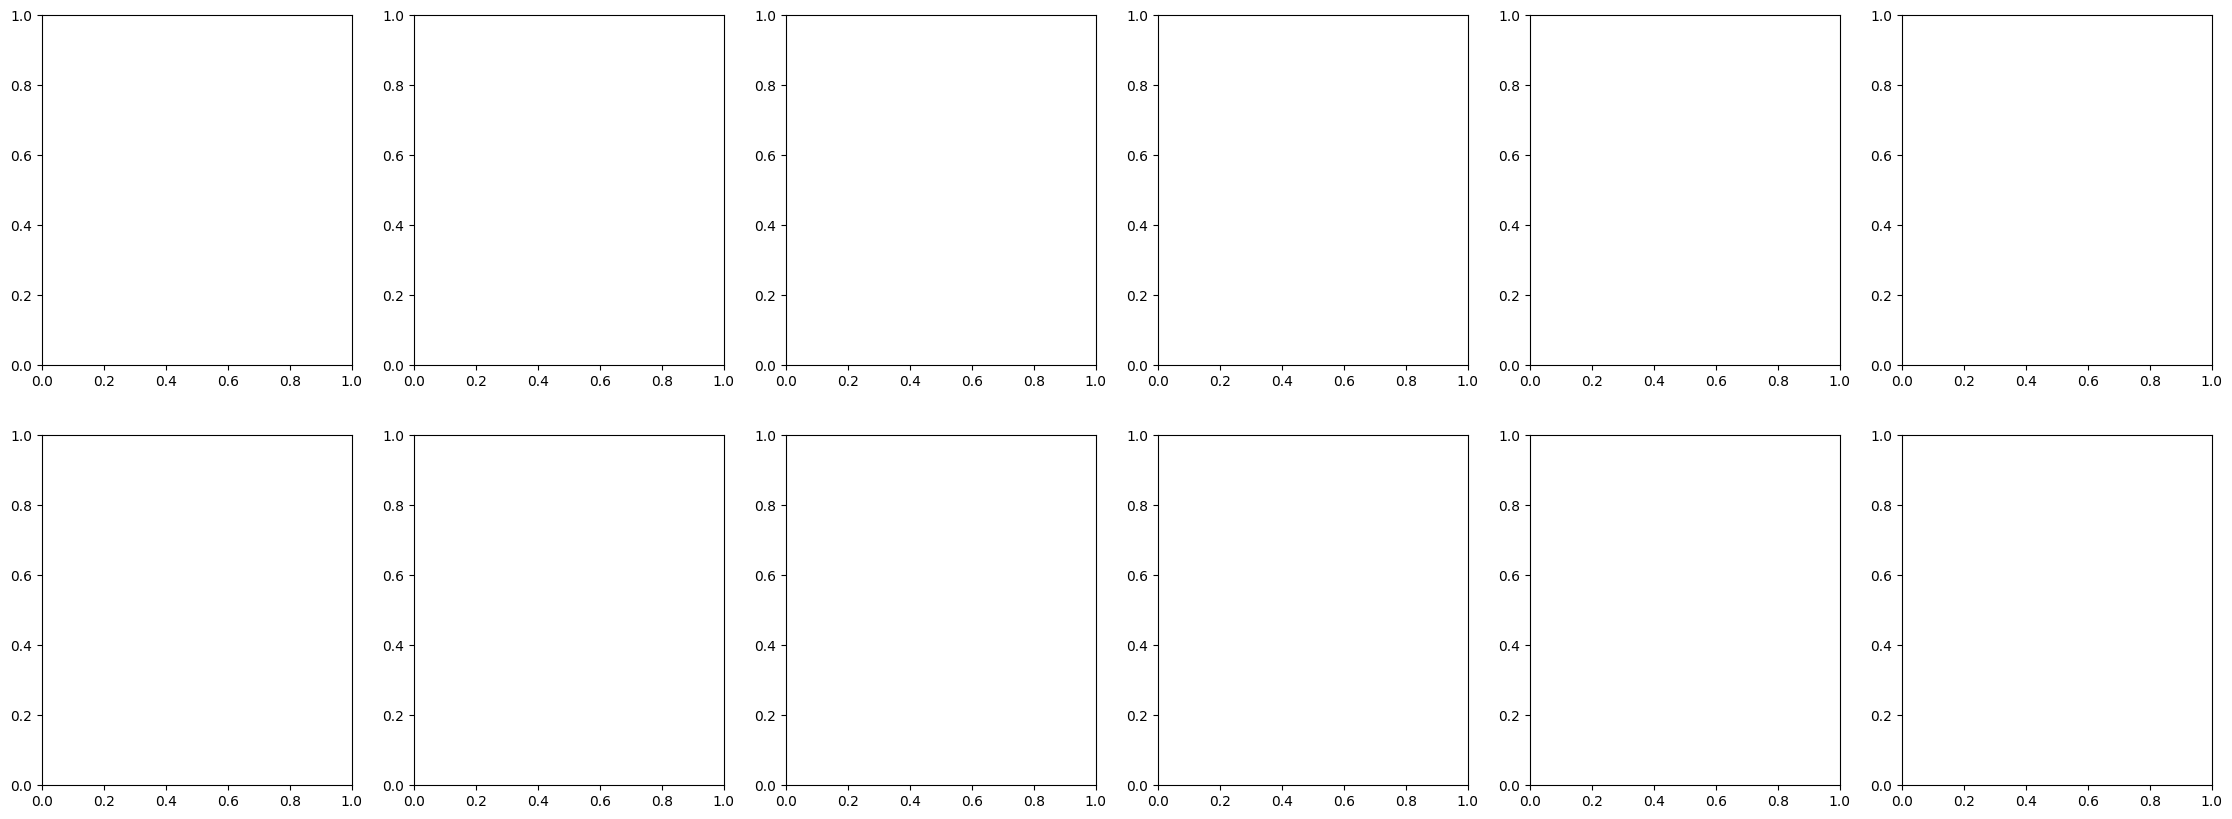

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
fig_quality, axes_quality = plt.subplots(ncols=6, nrows=2, figsize=(28,10))
fig_sp, axes_spe = plt.subplots(ncols=6, nrows=2, figsize=(28,10))

species = data["especie/ producto"].unique()

for ax, ax_q, ax_s, specie in zip(axes.ravel(), axes_quality.ravel(), axes_spe.ravel(), species):

    # -----------------------------
    # 1. Selección y preparación
    # -----------------------------
    df = data[data["especie/ producto"] == specie].sort_values(
            by=["year", "month_num"], ascending=True
        ).reset_index(drop=True)

    df.index = pd.date_range(start="2019-01-01", periods=len(df), freq="ME")

    df_price = df["price"]

    # -----------------------------
    # 2. ADF test
    # -----------------------------
    result = adfuller(df_price)
    print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

    # -----------------------------
    # 3. PACF + umbrales
    # -----------------------------
    nlags = 20
    N = len(df_price)
    conf = 1.96 / np.sqrt(N)

    plot_pacf(df_price, lags=nlags, ax=ax)
    ax.axhline(conf, color="red", linestyle="--", linewidth=1)
    ax.axhline(-conf, color="red", linestyle="--", linewidth=1)
    ax.set_title(f"{specie}, ADF p={round(result[1], 3)}")

    pacf_vals, confint = pacf(df_price, nlags=nlags, alpha=0.05)

    significant_lags = []
    for lag in range(1, nlags+1):
        lower, upper = confint[lag]
        if pacf_vals[lag] < lower or pacf_vals[lag] > upper:
            significant_lags.append(lag)

    print("Significant PACF lags:", significant_lags)

    # -----------------------------
    # 4. Modelo Prophet
    # -----------------------------
    df_prophet = pd.DataFrame({
        "ds": df.index,
        "y": df_price.values
    })

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive"
    )

    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=0, freq="M")
    forecast = model.predict(future)

    pred = forecast["yhat"].values

    # -----------------------------
    # 5. Métrica (RMSE)
    # -----------------------------
    rmse = mean_squared_error(df_price.values, pred) ** 0.5

    # -----------------------------
    # 6. Plot calidad
    # -----------------------------
    ax_q.scatter(df_price.values, pred, s=10)
    ax_q.set_title(f"{specie} | RMSE={rmse:.2f}")
    ax_q.set_xticks([])
    ax_q.set_yticks([])

    # -----------------------------
    # 7. Serie original
    # -----------------------------
    ax_s.plot(df.index, df_price)
    ax_s.set_title(specie)

plt.tight_layout()


/home/angel/Documents/Produccion-Ganadera-Avicola/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/angel/Documents/Produccion-Ganadera-Avicola/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/angel/Documents/Produccion-Ganadera-Avicola/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/home/angel/Documents/Produccion-Ganadera-Avicola/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecate

ave
RMSE=0.23 | R²=0.95 | Ljung-Box p=0.000
ovino
RMSE=0.02 | R²=0.68 | Ljung-Box p=0.000
porcino
RMSE=0.06 | R²=0.86 | Ljung-Box p=0.000
vacuno
RMSE=0.04 | R²=0.83 | Ljung-Box p=0.000
caprino
RMSE=0.01 | R²=0.47 | Ljung-Box p=0.000
alpaca
RMSE=0.03 | R²=0.90 | Ljung-Box p=0.000
llama
RMSE=0.07 | R²=0.89 | Ljung-Box p=0.000
huevo gallina
RMSE=0.19 | R²=0.85 | Ljung-Box p=0.000
fibra alpaca
RMSE=0.37 | R²=0.60 | Ljung-Box p=0.002
fibra llama
RMSE=0.27 | R²=0.98 | Ljung-Box p=0.005
lana ovino
RMSE=0.15 | R²=0.67 | Ljung-Box p=0.047


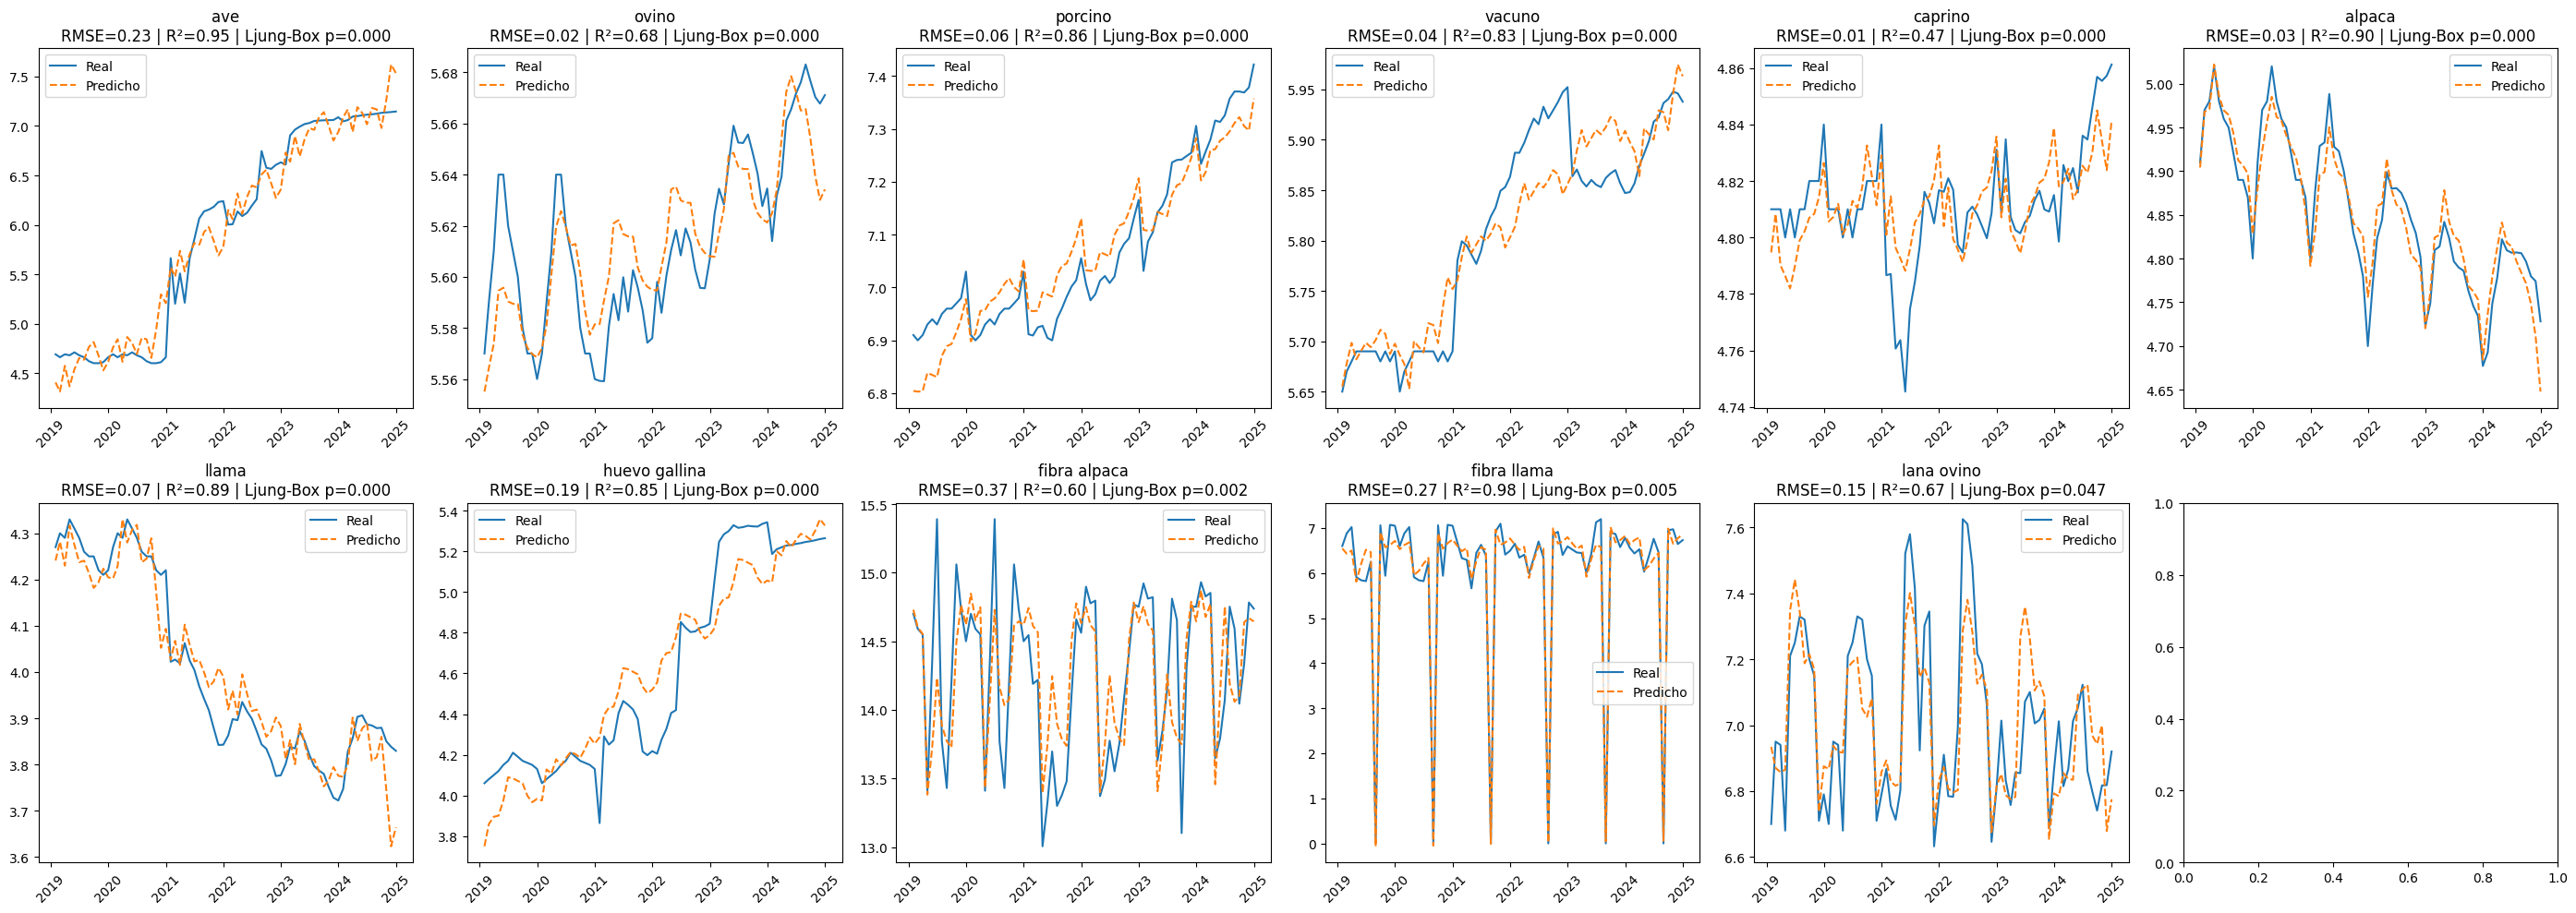

In [235]:
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(28,10))

species = data["especie/ producto"].unique()

for ax, specie in zip(axes.ravel(), species):
    
    df = data[data["especie/ producto"]==specie].sort_values(
        by=["year","month_num"], ascending=True
    ).reset_index(drop=True)
    df.index = pd.date_range(start="2019-01-01", periods=len(df), freq="ME")

    y = df["price"]

    # Fourier model
    fourier = CalendarFourier(freq="A", order=3)
    dp = DeterministicProcess(
        index=df.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )

    X = dp.in_sample()

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # ==========================
    #     MÉTRICAS
    # ==========================
    rmse = mean_squared_error(y, y_pred) ** 0.5
    r2 = r2_score(y, y_pred)

    # Residuos
    residuals = y - y_pred

    # Test de Ljung–Box (autocorrelación en residuos)
    lb_pvalue = acorr_ljungbox(residuals, lags=[12], return_df=True)["lb_pvalue"].iloc[0]

    # ==========================
    #     PLOT
    # ==========================
    ax.plot(df.index, y, label="Real")
    ax.plot(df.index, y_pred, label="Predicho", linestyle="--")

    ax.set_title(
        f"{specie}\nRMSE={rmse:.2f} | R²={r2:.2f} | Ljung-Box p={lb_pvalue:.3f}"
    )
    print(f"{specie}\nRMSE={rmse:.2f} | R²={r2:.2f} | Ljung-Box p={lb_pvalue:.3f}")
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
df_diff

2019-02-28    0.000000
2019-03-31    0.000000
2019-04-30   -0.010000
2019-05-31    0.010000
2019-06-30   -0.010000
                ...   
2024-08-31    0.011447
2024-09-30    0.010742
2024-10-31   -0.001427
2024-11-30    0.001809
2024-12-31    0.003997
Freq: ME, Name: price, Length: 71, dtype: float64

In [201]:

df = data[data["especie/ producto"]=="caprino"].sort_values( by=["year","month_num"], ascending=True).reset_index(drop=True)

In [202]:
df.index = pd.date_range(start="2019-01-01", periods=len(df), freq="M")

/tmp/ipykernel_81781/291119190.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index = pd.date_range(start="2019-01-01", periods=len(df), freq="M")


In [203]:
df.head()

,especie/ producto,month,price,year,month_num
2019-01-31,caprino,ene,4.81,2019,1
2019-02-28,caprino,feb,4.81,2019,2
2019-03-31,caprino,mar,4.81,2019,3
2019-04-30,caprino,abr,4.80,2019,4
2019-05-31,caprino,may,4.81,2019,5


In [204]:
result = adfuller(df["price"])
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = -2.136, p-value = 0.230


In [205]:
df_diff = df["price"].diff().dropna()

In [206]:
df_diff

2019-02-28    0.000000
2019-03-31    0.000000
2019-04-30   -0.010000
2019-05-31    0.010000
2019-06-30   -0.010000
                ...   
2024-08-31    0.011447
2024-09-30    0.010742
2024-10-31   -0.001427
2024-11-30    0.001809
2024-12-31    0.003997
Freq: ME, Name: price, Length: 71, dtype: float64

In [207]:
result = adfuller(df_diff)
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = -2.087, p-value = 0.250


In [208]:
df_diff.shape

(71,)

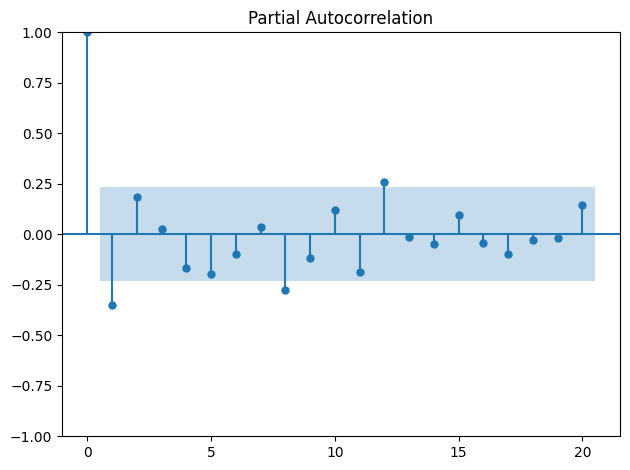

In [209]:
pacf = plot_pacf(df_diff, lags=20)
plt.tight_layout()
plt.show()

In [211]:
from statsmodels.tsa.stattools import pacf
import numpy as np

nlags = 20
pacf_vals, confint = pacf(df_diff, nlags=nlags, alpha=0.05)

significant_lags = []
for lag in range(1, nlags+1):
    lower, upper = confint[lag]
    value = pacf_vals[lag]

    if value < lower or value > upper:
        significant_lags.append(lag)

print("Significant PACF lags:", significant_lags)


Significant PACF lags: []


In [193]:
confint

array([[ 1.        ,  1.        ],
       [-0.58868247, -0.12347261],
       [-0.04098216,  0.4242277 ],
       [-0.20409992,  0.26110994],
       [-0.40922845,  0.05598141],
       [-0.44472733,  0.02048253],
       [-0.34257736,  0.1226325 ],
       [-0.19067867,  0.27453119],
       [-0.54946638, -0.08425652],
       [-0.37682318,  0.08838668],
       [-0.08596078,  0.37924908],
       [-0.46763935, -0.00242949],
       [ 0.09921937,  0.56442923],
       [-0.26172566,  0.2034842 ],
       [-0.29834078,  0.16686908],
       [-0.07252442,  0.39268544],
       [-0.32224755,  0.14296231],
       [-0.36938353,  0.09582633],
       [-0.25803915,  0.20717072],
       [-0.27817635,  0.18703351],
       [-0.0026988 ,  0.46251107]])

In [192]:

# The threshold is the confidence interval
upper = confint[:, 1]  # upper bound
lower = confint[:, 0]  # lower bound

# Find first lag where PACF crosses threshold (outside confidence interval)
for lag in range(0, nlags+1):
    if pacf_vals[lag] > upper[lag] or pacf_vals[lag] < lower[lag]:
        print(f"Lag {lag} crosses threshold: PACF = {pacf_vals[lag]:.3f}")
        break

In [212]:
p = 4
model = AutoReg(df_diff, lags=p, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  price   No. Observations:                   71
Model:                     AutoReg(4)   Log Likelihood                 197.383
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Tue, 09 Dec 2025   AIC                           -382.766
Time:                        15:47:14   BIC                           -369.538
Sample:                    06-30-2019   HQIC                          -377.532
                         - 12-31-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.612      0.540      -0.002       0.004
price.L1      -0.2821      0.120     -2.345      0.019      -0.518      -0.046
price.L2       0.2272      0.125      1.822      0.0

In [124]:
# 2️⃣ Forecast using the fitted model
forecast_diff = model_fit.predict(
    start=len(df_diff),   # start forecasting after the last data point
    end=len(df_diff)+4    # forecast 5 steps ahead
)

# 3️⃣ Convert forecasted differences to original prices
forecast_price = df["price"].iloc[-1] + forecast_diff.cumsum()
print(forecast_price)

2025-01-31    4.860850
2025-02-28    4.861973
2025-03-31    4.862548
2025-04-30    4.863316
2025-05-31    4.864016
Freq: ME, dtype: float64


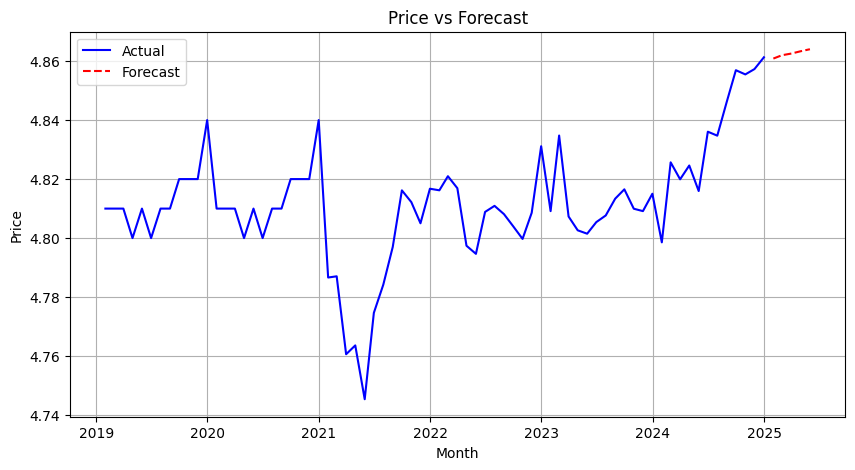

In [125]:
# 5️⃣ Plot actual and forecast
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["price"], label="Actual", color="blue")
plt.plot(forecast_price.index, forecast_price, label="Forecast", color="red", linestyle="--")
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Price vs Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [126]:
pred_diff = model_fit.predict(start=0, end=len(df_diff)-1)


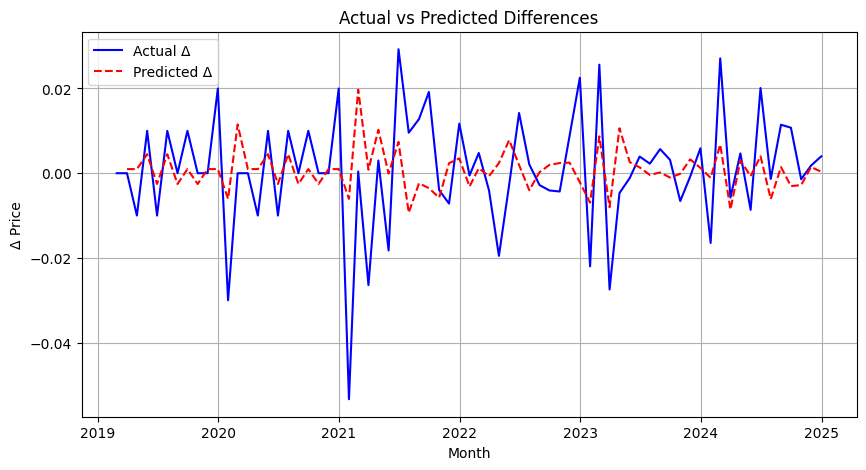

In [127]:
# 4️⃣ Plot actual vs predicted differences
plt.figure(figsize=(10,5))
plt.plot(df_diff.index, df_diff, label="Actual Δ", color="blue")
plt.plot(df_diff.index, pred_diff, label="Predicted Δ", color="red", linestyle="--")
plt.xlabel("Month")
plt.ylabel("Δ Price")
plt.title("Actual vs Predicted Differences")
plt.legend()
plt.grid(True)
plt.show()

In [128]:
df_diff.diff().dropna()

2019-03-31    0.000000
2019-04-30   -0.010000
2019-05-31    0.020000
2019-06-30   -0.020000
2019-07-31    0.020000
                ...   
2024-08-31    0.012792
2024-09-30   -0.000704
2024-10-31   -0.012169
2024-11-30    0.003235
2024-12-31    0.002188
Freq: ME, Name: price, Length: 70, dtype: float64

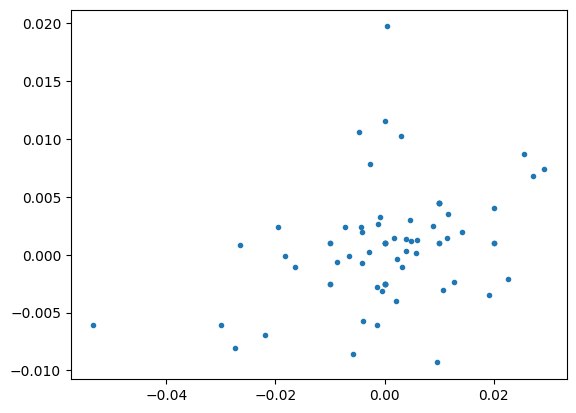

In [129]:
plt.plot(df_diff, pred_diff, ".")